In [ ]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [27]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = 50
EPOCHS = 10

# Dataset 1

In [2]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [3]:
# Retrieve data directly from Stanford data source
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -qq 'tiny-imagenet-200.zip'
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

URL transformed to HTTPS due to an HSTS policy
--2024-04-01 23:57:44--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  14.1MB/s    in 25s     

2024-04-01 23:58:10 (9.37 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [28]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

In [30]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
# tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: load_image(os.path.join(root, row.Class ,"images", row.File)), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)
tiny_imagenet_train

,File,X,Y,H,W,Class,label_name
0,tiny-imagenet-200/train/n07715103/images/n0771...,1,1,59,63,n07715103,cauliflower
1,tiny-imagenet-200/train/n03837869/images/n0383...,18,0,47,55,n03837869,obelisk
2,tiny-imagenet-200/train/n03804744/images/n0380...,28,1,63,63,n03804744,nail
3,tiny-imagenet-200/train/n09193705/images/n0919...,0,33,63,63,n09193705,alp
4,tiny-imagenet-200/train/n03444034/images/n0344...,14,31,63,63,n03444034,go-kart
...,...,...,...,...,...,...,...
99995,tiny-imagenet-200/train/n04259630/images/n0425...,13,1,45,28,n04259630,sombrero
99996,tiny-imagenet-200/train/n04366367/images/n0436...,1,0,63,63,n04366367,suspension bridge
99997,tiny-imagenet-200/train/n07614500/images/n0761...,0,7,58,43,n07614500,ice cream
99998,tiny-imagenet-200/train/n04149813/images/n0414...,1,15,36,54,n04149813,scoreboard


In [47]:
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [32]:
# Validation dataset creation 

# Display first 20 entries of resulting dictionary
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
# tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: load_image(os.path.join(VALID_DIR,"images", row.File)), axis=1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)
tiny_imagenet_valid

,File,Class,X,Y,H,W,label_name
0,tiny-imagenet-200/val/images/val_6131.JPEG,n03617480,13,18,54,63,kimono
1,tiny-imagenet-200/val/images/val_3365.JPEG,n03042490,0,23,63,63,cliff dwelling
2,tiny-imagenet-200/val/images/val_1883.JPEG,n02395406,37,24,62,49,hog
3,tiny-imagenet-200/val/images/val_3267.JPEG,n01784675,13,11,40,54,centipede
4,tiny-imagenet-200/val/images/val_624.JPEG,n03854065,14,0,63,63,organ
...,...,...,...,...,...,...,...
9995,tiny-imagenet-200/val/images/val_2282.JPEG,n03804744,1,8,62,61,nail
9996,tiny-imagenet-200/val/images/val_1923.JPEG,n07695742,29,0,60,14,pretzel
9997,tiny-imagenet-200/val/images/val_2403.JPEG,n02837789,8,10,35,57,bikini
9998,tiny-imagenet-200/val/images/val_7447.JPEG,n03838899,0,14,31,63,oboe


In [33]:

limited_classes = list(class_to_label_number_dict.keys())[:NUM_CLASSES]
train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.Class.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.Class.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)
tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)

tiny_imagenet_train

['n07715103', 'n07614500', 'n04074963', 'n02403003', 'n02085620', 'n03992509', 'n03014705', 'n04070727', 'n02699494', 'n09332890', 'n02909870', 'n02977058', 'n03126707', 'n03837869', 'n03970156', 'n02999410', 'n09256479', 'n07753592', 'n04417672', 'n02233338', 'n02814860', 'n01768244', 'n12267677', 'n02927161', 'n03902125', 'n03404251', 'n02837789', 'n02486410', 'n02236044', 'n02002724', 'n02480495', 'n04532106', 'n04118538', 'n03544143', 'n04133789', 'n03388043', 'n03770439', 'n04254777', 'n07734744', 'n01882714', 'n01984695', 'n03085013', 'n04371430', 'n04356056', 'n01944390', 'n02113799', 'n02504458', 'n03250847', 'n01774750', 'n02364673']


In [37]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.uint8)  # Ensure image data type is uint8
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# creating train dataset loader
image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((image, labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((image, labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [57]:
# input size
print(ds_train.element_spec)

(TensorSpec(shape=(64, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 50), dtype=tf.float32, name=None))


Image shape: (64, 224, 224, 3)


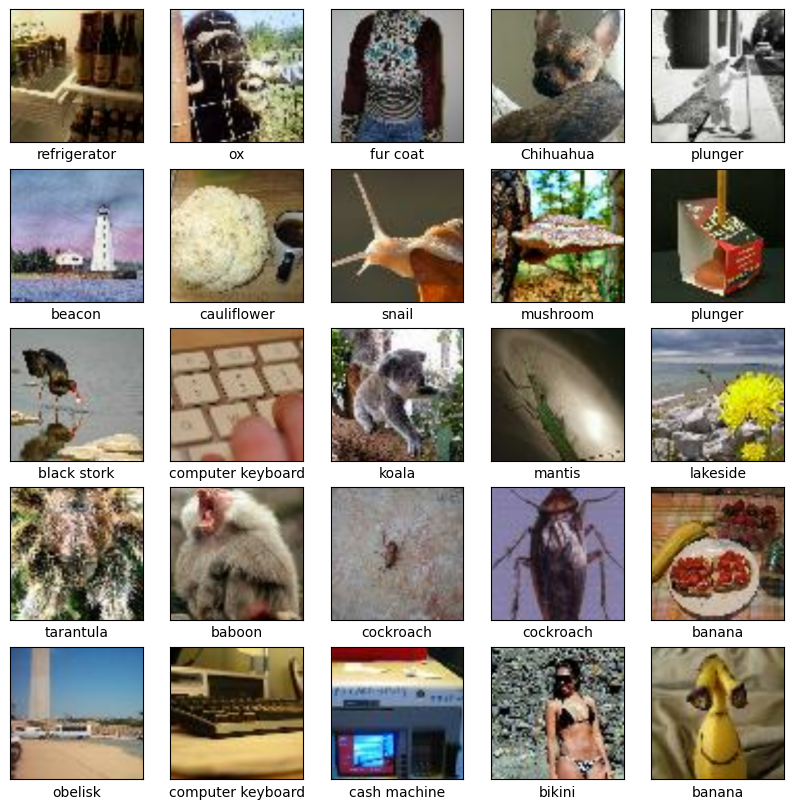

In [53]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



Image shape: (64, 224, 224, 3)


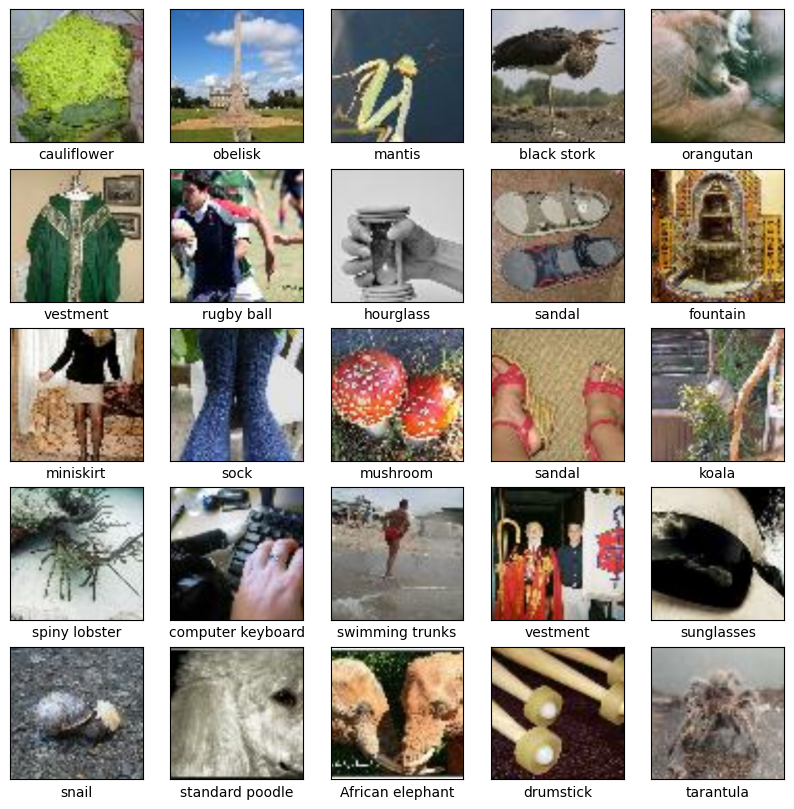

In [54]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



In [41]:
def efficientNetB0_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [42]:
model = efficientNetB0_model(num_classes=NUM_CLASSES)
model_output = model.fit(ds_train, epochs=EPOCHS, validation_data=ds_valid)


Epoch 1/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 280s 707ms/step - accuracy: 0.6143 - loss: 2.0050 - val_accuracy: 0.7576 - val_loss: 0.9699
Epoch 2/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 279s 716ms/step - accuracy: 0.7751 - loss: 0.8632 - val_accuracy: 0.7672 - val_loss: 0.8795
Epoch 3/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1591s 4s/step - accuracy: 0.7937 - loss: 0.7394 - val_accuracy: 0.7680 - val_loss: 0.9493
Epoch 4/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 1158s 3s/step - accuracy: 0.7944 - loss: 0.7289 - val_accuracy: 0.7572 - val_loss: 0.9486
Epoch 5/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 284s 728ms/step - accuracy: 0.7962 - loss: 0.7179 - val_accuracy: 0.7588 - val_loss: 1.0063
Epoch 6/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 296s 759ms/step - accuracy: 0.7995 - loss: 0.7332 - val_accuracy: 0.7572 - val_loss: 1.0330
Epoch 7/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 316s 809ms/step - accuracy: 0.7960 - loss: 0.7428 - val_accuracy: 0.7580 - val_loss: 1.0571
Epoch 8/10
390/390 ━━━━━━━━━━━━━━━━━━━━ 324s 830ms/step - accuracy: 0.7945 - los

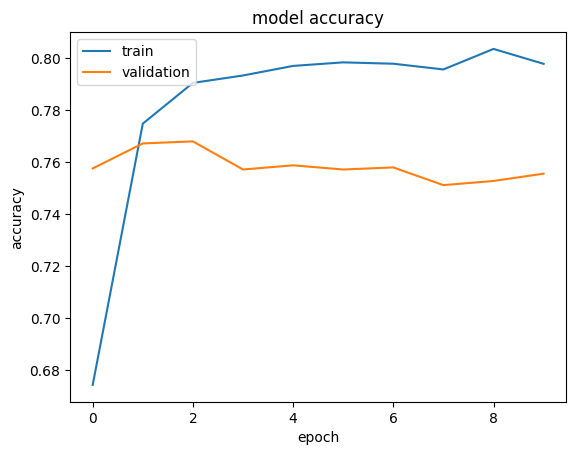

In [43]:
# for 50 classes
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(model_output)

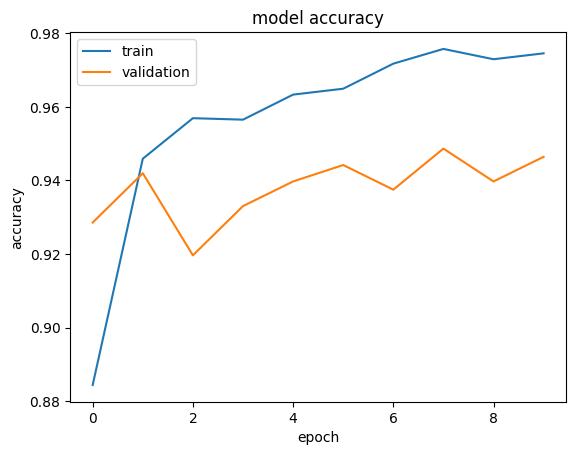

In [16]:
# For 5 classes
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
plot_hist(model_output)

In [ ]:
# import tensorflow as tf
# # set the same random seed.
# tf.random.set_seed(42)
# tf.compat.v1.set_random_seed(42)
# tf.experimental.numpy.random.seed(42)

# cnn_model = tf.keras.Sequential([
#     tf.keras.layers.Reshape((64, 64, 3), input_shape=(12288,)),
#     tf.keras.layers.Conv2D(64, (7, 7), activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Conv2D(128, (2, 2), activation='relu'),
#     tf.keras.layers.MaxPool2D(),
#     # tf.keras.layers.Conv2D(2, (2, 2), activation='relu'),
#     # tf.keras.layers.MaxPool2D(),
#     # tf.keras.layers.Conv2D(2, (2, 2), activation='relu'),
#     # tf.keras.layers.MaxPool2D(),
#     # tf.keras.layers.Conv2D(1, (2, 2), activation='relu'),
#     # tf.keras.layers.MaxPool2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(1000, activation='relu'),
#     tf.keras.layers.Dense(100)
# ])
# total_parameters = cnn_model.count_params()
# print("Total parameters:", total_parameters)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.09,
#     decay_steps=100,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

# # compile the model
# cnn_model.compile(optimizer=optimizer,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_accuracy",
#         # "no longer improving" being defined as "for at least 3 epochs"
#         patience=3,
#         verbose=1,
#     )
# ]
# # train the model with early-stopping
# cnn_model.fit(
#     tiny_imagenet_train.File.apply(pd.Series), tiny_imagenet_train.label_number, 
#     batch_size=50, epochs=100,
#     callbacks=callbacks,
#     validation_data=(tiny_imagenet_valid.File.apply(pd.Series), tiny_imagenet_valid.label_number))
# # evaluate on the original test set
# # test_loss, test_acc = cnn_model.evaluate(Xtest,  Ytest, verbose=2)
# # print('In-domain test accuracy:', test_acc)

# Regularization Techniques for Dataset 1

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.

# Dataset 2

In [ ]:
# 2. nltk-brown + nltk-treebank + nltk-conll2000
#   (a) Dataset Summary - The combination of these 3 datasets gives us a large corpus of
#                       textual data that can be used for training a model that performs sequence labeling with
#                       a total size of 72,000+ tagged sentences. The nltk library takes the base dataset and
#                       performs tokenization to prepare it for the task of sequence labeling.
#   (b) Data Feature Dimensions -
#         i. Input Sequence - A sentence in english.
#        ii. Output Sequence - POS tags of each word of the sentence.

In [ ]:
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')


In [ ]:
treebank = treebank.tagged_sents(tagset='universal')
brown = brown.tagged_sents(tagset='universal')
conll2000 = conll2000.tagged_sents(tagset='universal')
print(treebank[0])
print(brown[0])
print(conll2000[0])

In [ ]:
def create_dataset(data):
    sentences = []
    pos_tags = []

    for sequence in data:
        sentence = []
        tags = []
        for seq in sequence:         
            sentence.append(seq[0])
            tags.append(seq[1])
            
        sentences.append(sentence)
        pos_tags.append(tags)
    return pd.DataFrame(zip(sentences, pos_tags), columns=["sentences", "pos_tags"])

In [ ]:
corpus_dataset = create_dataset(treebank + brown + conll2000)
corpus_dataset.head(5)

# Regularization Techniques for Dataset 2

In [ ]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#       - RandomErasing is concerned about removing and randomly adding information on the
#         blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#         Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 2 - applying RandomSynonymReplacement and MaxDropout together. Applied to Dataset2.